# EfficientDet Training On A Custom Dataset

In [2]:
import sys
import os

sys.path.append('/detector/')
os.chdir('/detector')

In [4]:
from src.config import Config
from src.datamodule import BirdViewDM
from src.lighting_module import BirdViewVehicleModule


config_file = "/detector/configs/config.yaml"
config = Config.from_yaml(config_file)

model = BirdViewVehicleModule(config)
datamodule = BirdViewDM(config)

[Warning] Ignoring Error(s) in loading state_dict for EfficientDetBackbone:
	size mismatch for classifier.header.pointwise_conv.conv.weight: copying a param with shape torch.Size([810, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([18, 64, 1, 1]).
	size mismatch for classifier.header.pointwise_conv.conv.bias: copying a param with shape torch.Size([810]) from checkpoint, the shape in current model is torch.Size([18]).


In [6]:
from clearml import Task
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint

task = Task.init(
    project_name=config.project_name,
    task_name=f'{config.experiment_name}',
    auto_connect_frameworks=True,
)
task.connect(config.dict())

experiment_save_path = os.path.join('./weights/experiments', 'checkpoints')
os.makedirs(experiment_save_path, exist_ok=True)
print('Task id:', task.get_task_output_log_web_page(task.id))

checkpoint_callback = ModelCheckpoint(
    experiment_save_path,
    monitor=config.monitor_metric,
    mode=config.monitor_mode,
    save_top_k=1,
    filename=f'epoch_{{epoch:02d}}-{{{config.monitor_metric}:.3f}}',
)
trainer = pl.Trainer(
    max_epochs=1,
    accelerator="gpu",
    devices=[0],
    log_every_n_steps=20,
    callbacks=[
        checkpoint_callback,
        EarlyStopping(monitor=config.monitor_metric, patience=4, mode=config.monitor_mode),
        LearningRateMonitor(logging_interval='epoch'),
    ],
)

trainer.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Task id: https://app.clear.ml/projects/*/experiments/1c5a584dd02c444980c0b3ee7f1c66cd/output/log
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                 | Params
-----------------------------------------------
0 | model | EfficientDetBackbone | 3.8 M 
-----------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.314    Total estimated model params size (MB)


Done (t=0.15s)
creating index...
index created!


Sanity Checking: |                                                                                            …

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


In [3]:
import os 

os.chdir('/detector')

In [4]:
!pwd

/detector


In [12]:
# consider this is a simple dataset, train head will be enough.
! python train.py -c 0 -p birdview_vehicles --head_only True --lr 5e-3 --batch_size 32 --load_weights weights/efficientdet-d0.pth  --num_epochs 10 --save_interval 100

# the loss will be high at first
# don't panic, be patient,
# just wait for a little bit longer

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[Warning] Ignoring Error(s) in loading state_dict for EfficientDetBackbone:
	size mismatch for classifier.header.pointwise_conv.conv.weight: copying a param with shape torch.Size([810, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([18, 64, 1, 1]).
	size mismatch for classifier.header.pointwise_conv.conv.bias: copying a param with sha

In [20]:
! python train.py -c 0 -p barcode --head_only True --lr 10e-3 --batch_size 32 --load_weights weights/efficientdet-d0.pth  --num_epochs 10 --save_interval 100


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[Warning] Ignoring Error(s) in loading state_dict for EfficientDetBackbone:
	size mismatch for classifier.header.pointwise_conv.conv.weight: copying a param with shape torch.Size([810, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([9, 64, 1, 1]).
	size mismatch for classifier.header.pointwise_conv.conv.bias: copying a param with shap

In [ ]:
! python train.py -c 0 -p birdview_vehicles --head_only False --lr 1e-3 --batch_size 16 --load_weights last  --num_epochs 16 --save_interval 100

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
using weights logs//birdview_vehicles/efficientdet-d0_8_306.pth
[Info] loaded weights: efficientdet-d0_8_306.pth, resuming checkpoint from step: 306
Step: 344. Epoch: 4/16. Iteration: 69/69. Cls loss: 0.33619. Reg loss: 1.66370. Total loss: 1.99990: 100% 69/69 [00:47<00:00,  1.46it/s]
Val. Epoch: 4/16. Classification loss: 0.76417. Regression loss: 4.01592. Total loss: 4.78009
Step: 399. Epoch: 5/16. Iteration: 55/69. Cls loss: 0.33938. Reg loss: 1.30131. Total loss: 1.64069:  78% 54/69 [00:52<00:11,  1.27it/s]checkpoint...
Step: 413. Epoch: 5/16. Iteration: 69/69. Cls loss: 0.22673. Reg loss: 1.30066. Total loss: 1.52739: 100% 69/69 [01:03<00:00,  1.08it/s]
Val. Epoch: 5/16. Classification loss: 0.40379. Regression loss: 1.87583. Total loss: 2.27962
Step: 482. Epoch: 6/16. Iteration: 69/69. Cls loss: 0.21152. Reg loss: 1.

In [22]:
#get latest weight file
# %cd logs/birdview_vehicles
# weight_file = !ls -Art | grep efficientdet
# %cd ../..

#uncomment the next line to specify a weight file
#weight_file[-1] = 'efficientdet-d0_49_1400.pth'

! python coco_eval.py -c 0 -p barcode -w "logs/barcode/efficientdet-d0_9_100.pth"

running coco-style evaluation on project barcode, weights logs/barcode/efficientdet-d0_9_100.pth...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
100%|███████████████████████████████████████████| 91/91 [00:10<00:00,  9.07it/s]
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
BBox
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:

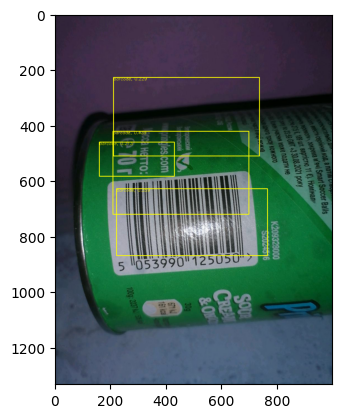

In [23]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

compound_coef = 0
force_input_size = None  # set None to use default size
img_path = 'datasets/barcode/val/0a0de03b-710c-40e4-8f0e-5fa0ee9ef0a5--ru.b7135dcc-0514-43de-a53d-87f41aae71e4.jpg'

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = [ 'barcode' ]

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)
weight_file = 'logs/barcode/efficientdet-d0_9_100.pth'


if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(0.7, 1.4), (1.0, 1.0), (1.5, 0.7)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

model.load_state_dict(torch.load(weight_file))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

out = invert_affine(framed_metas, out)

for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)

        plt.imshow(ori_imgs[i])



In [24]:
out

[{'rois': array([[208.0914 , 422.92343, 697.9275 , 721.5632 ],
         [221.58873, 629.75226, 764.09485, 870.2182 ],
         [210.21408, 228.47745, 735.0316 , 511.65417],
         [159.77773, 461.48935, 429.9275 , 584.4463 ]], dtype=float32),
  'class_ids': array([0, 0, 0, 0]),
  'scores': array([0.43932036, 0.35929874, 0.2292474 , 0.21312778], dtype=float32)}]

In [26]:
weights_path = 'logs/barcode/efficientdet-d0_9_100.pth'

In [28]:
import torch

weights = torch.load(weights_path)

In [30]:
weights



In [ ]:
from typing import List

from omegaconf import OmegaConf
from pydantic import BaseModel


class LossConfig(BaseModel):
    name: str
    weight: float
    loss_fn: str
    loss_kwargs: dict


class DataConfig(BaseModel):
    loader_type: str
    data_path: str
    batch_size: int
    n_workers: int
    num_iterations: int
    train_size: float
    width: int
    height: int


class Config(BaseModel):
    project_name: str
    compound_coef: int
    experiment_name: str
    data_config: DataConfig
    n_epochs: int
    num_classes: int
    accelerator: str
    device: int
    monitor_metric: str
    monitor_mode: str
    model_kwargs: dict
    optimizer: str
    optimizer_kwargs: dict
    scheduler: str
    scheduler_kwargs: dict
    losses: List[LossConfig]

    @classmethod
    def from_yaml(cls, path: str) -> 'Config':
        cfg = OmegaConf.to_container(OmegaConf.load(path), resolve=True)
        return cls(**cfg)

In [31]:
import pytorch_lightning as pl


In [ ]:
import pytorch_lightning as pl

from efficientdet.loss import FocalLoss
from backbone import EfficientDetBackbone

class BarcodeModule(pl.LightningModule):
    def __init__(self, config: Config):
        super().__init__()
        self._config = config
        self.model = EfficientDetBackbone(num_classes=self._config.num_classes, compound_coef=self._config.compound_coef)
        self._loss = FocalLoss()
        # metrics = get_metrics(
        #     num_classes=self._config.num_classes,
        #     num_labels=self._config.num_classes,
        #     task='multilabel',
        #     average='macro',
        #     threshold=0.5,
        # )
        # self._valid_metrics = metrics.clone(prefix='val_')
        # self._test_metrics = metrics.clone(prefix='test_')

    def forward(self, imgs: torch.Tensor):
        return self.model(imgs)
    
    def configure_optimizers(self):
        optimizer = load_object(self._config.optimizer)(
            self._model.parameters(),
            **self._config.optimizer_kwargs,
        )
        scheduler = load_object(self._config.scheduler)(optimizer, **self._config.scheduler_kwargs)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': self._config.monitor_metric,
                'interval': 'epoch',
                'frequency': 1,
            },
        }


    def training_step(self, batch, batch_idx):
        """
        Считаем лосс.
        """
        images, annotations = batch
        _, regression, classification, anchors = self(images)
        cls_loss, reg_loss = self._loss(classification, regression, anchors, annotations)
        pr_logits = self(images)
        return self._calculate_loss(pr_logits, gt_labels, 'train_')

    def validation_step(self, batch, batch_idx):
        """
        Считаем лосс и метрики.
        """
        images, gt_labels = batch
        pr_logits = self(images)
        self._calculate_loss(pr_logits, gt_labels, 'val_')
        pr_labels = torch.sigmoid(pr_logits)
        self._valid_metrics(pr_labels, gt_labels)

    def test_step(self, batch, batch_idx):
        """
        Считаем метрики.
        """
        images, gt_labels = batch
        pr_logits = self(images)
        pr_labels = torch.sigmoid(pr_logits)
        self._test_metrics(pr_labels, gt_labels)

    def on_validation_epoch_start(self) -> None:
        self._valid_metrics.reset()

    def on_validation_epoch_end(self) -> None:
        self.log_dict(self._valid_metrics.compute(), on_epoch=True)

    def on_test_epoch_end(self) -> None:
        self.log_dict(self._test_metrics.compute(), on_epoch=True)


        


In [ ]:
import pytorch_lightning as pl
import torch
from timm import create_model

from src.config import Config
from src.losses import get_losses
from src.metrics import get_metrics
from src.utils import load_object


class PosterModule(pl.LightningModule):
    def __init__(self, config: Config):
        super().__init__()
        self._config = config

        self._model = create_model(num_classes=self._config.num_classes, **self._config.model_kwargs)
        self._losses = get_losses(self._config.losses)
        metrics = get_metrics(
            num_classes=self._config.num_classes,
            num_labels=self._config.num_classes,
            task='multilabel',
            average='macro',
            threshold=0.5,
        )
        self._valid_metrics = metrics.clone(prefix='val_')
        self._test_metrics = metrics.clone(prefix='test_')

        self.save_hyperparameters()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._model(x)

    def configure_optimizers(self):
        optimizer = load_object(self._config.optimizer)(
            self._model.parameters(),
            **self._config.optimizer_kwargs,
        )
        scheduler = load_object(self._config.scheduler)(optimizer, **self._config.scheduler_kwargs)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': self._config.monitor_metric,
                'interval': 'epoch',
                'frequency': 1,
            },
        }

    def training_step(self, batch, batch_idx):
        """
        Считаем лосс.
        """
        images, gt_labels = batch
        pr_logits = self(images)
        return self._calculate_loss(pr_logits, gt_labels, 'train_')

    def validation_step(self, batch, batch_idx):
        """
        Считаем лосс и метрики.
        """
        images, gt_labels = batch
        pr_logits = self(images)
        self._calculate_loss(pr_logits, gt_labels, 'val_')
        pr_labels = torch.sigmoid(pr_logits)
        self._valid_metrics(pr_labels, gt_labels)

    def test_step(self, batch, batch_idx):
        """
        Считаем метрики.
        """
        images, gt_labels = batch
        pr_logits = self(images)
        pr_labels = torch.sigmoid(pr_logits)
        self._test_metrics(pr_labels, gt_labels)

    def on_validation_epoch_start(self) -> None:
        self._valid_metrics.reset()

    def on_validation_epoch_end(self) -> None:
        self.log_dict(self._valid_metrics.compute(), on_epoch=True)

    def on_test_epoch_end(self) -> None:
        self.log_dict(self._test_metrics.compute(), on_epoch=True)

    def _calculate_loss(
        self,
        pr_logits: torch.Tensor,
        gt_labels: torch.Tensor,
        prefix: str,
    ) -> torch.Tensor:
        total_loss = 0
        for cur_loss in self._losses:
            loss = cur_loss.loss(pr_logits, gt_labels)
            total_loss += cur_loss.weight * loss
            self.log(f'{prefix}{cur_loss.name}_loss', loss.item())
        self.log(f'{prefix}total_loss', total_loss.item())
        return total_loss